In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/")

In [2]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords

In [3]:
sns.set_theme()

In [4]:
from estimation_utils.diversity_metrics import NGramStats

In [5]:
metric_div = NGramStats()

In [6]:
stopwords_set = set(stopwords.words('english'))
stopwords_set.add("")

In [7]:
# stemming
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [8]:
def get_ngram_freqs(texts_list, N=1):
    data = metric_div._list_tokenized_lower_nopunct(texts_list)
    data_clean = [[stemmer.stem(word) for word in sent] for sent in data]
    ngram_freqs = metric_div._ngram_freqs(data_clean, N)
    return ngram_freqs

In [9]:
def filter_stop_words(ngram_freqs, return_type="freqs"):
    if return_type == "freqs":
        ngram_freqs_list = sorted([ngram_freqs[t] for t in ngram_freqs if t[0] not in stopwords_set], reverse=True)
    else:
        ngram_freqs_list = sorted([(ngram_freqs[t], t[0]) for t in ngram_freqs if t[0] not in stopwords_set], reverse=True)
    return ngram_freqs_list

In [10]:
dir = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/generated_texts/" 

file_name = "wikipedia--t5-bert-initial_last_-num_texts=8196-scale=0.0.json"
file_name = os.path.join(dir, file_name)
data = json.load(open(file_name, "r"))

texts = dict()
texts["GT"] = [d["GT"] for d in data]
texts["BASE"] = [d["GEN"] for d in data]

file_name = "wikipedia--t5-bert-self_cond_last_-num_texts=8196-scale=0.0.json"
file_name = os.path.join(dir, file_name)
data = json.load(open(file_name, "r"))
texts["SC"] = [d["GEN"] for d in data]

file_name = "hg_pretrained-wikipedia-clean-num_beams=1-num_texts=8192-cond_seg=[0.00, 0.67].json"
file_name = os.path.join(dir, file_name)
data = json.load(open(file_name, "r"))
texts["GPT"] = [d["GEN"] for d in data]

In [11]:
models_names = ["GT", "BASE", "SC"]

In [12]:
ngram_freqs = dict()
for key in models_names:
    ngram_freqs[key] = get_ngram_freqs(texts[key])

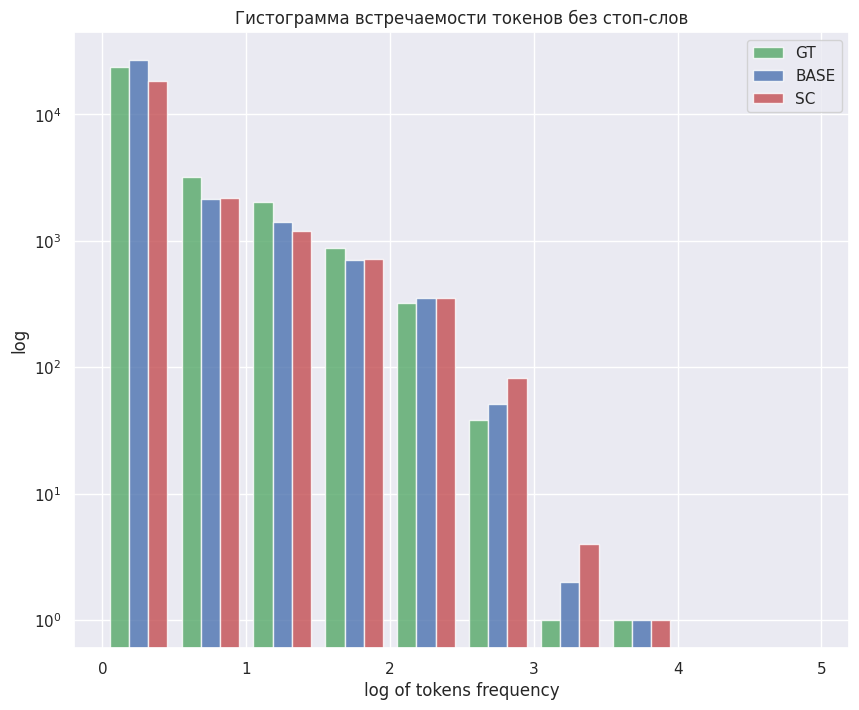

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))


ax.set_title("Гистограмма встречаемости токенов без стоп-слов")


vis_dict = dict()

for key in models_names:
    #x = list(ngram_freqs[key].values())
    x = filter_stop_words(ngram_freqs[key])
    x = np.array(x)
    #x = x[x > 1]
    #x = np.clip(x, a_min=0, a_max=1000)
    x = np.log10(x)
    vis_dict[key] = x

x_list = [vis_dict[key] for key in models_names]
colors = ['g', 'b', 'r', 'y', 'm'][:len(models_names)]
plt.hist(x_list, color=colors, alpha=0.8, label=models_names, bins=10, range=[0, 5])
    
# ax.hist(x, label=key, density=True, bins=10, alpha=0.5, facecolor="None", edgecolor="blue")
ax.set_yscale('log')
ax.set_xlabel("log of tokens frequency")
ax.set_ylabel("log")

#ax.set(xticks=np.arange(15, 37, 2))
#ax.grid(color='black', linestyle='-', linewidth=2)

plt.legend()

In [61]:
key = "GT"
x1 = list(ngram_freqs[key].values())
len(x1), sum(x1)

(38260, 334722)

In [62]:
x2 = filter_stop_words(ngram_freqs[key])
len(x2), sum(x2)

(38122, 198663)

In [63]:
sum(x1) - sum(x2)

136059

In [134]:
nfreq_list_1 = dict()

In [168]:
for key in models_names:
    nfreq_list = filter_stop_words(ngram_freqs[key], None)
    nfreq_list_1[key] = set([t[1] for t in nfreq_list if t[0] == 2])

In [169]:
len(nfreq_list_1["GT"]), len(nfreq_list_1["BASE"]), len(nfreq_list_1["GT"] & nfreq_list_1["BASE"])

(5573, 2929, 382)

In [170]:
len(nfreq_list_1["GT"]), len(nfreq_list_1["SC"]), len(nfreq_list_1["GT"] & nfreq_list_1["SC"])

(5573, 3298, 378)

In [171]:
data = metric_div._list_tokenized_lower_nopunct(texts["GT"])

In [177]:
# stemming
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [184]:
data_clean = [[stemmer.stem(word) for word in sent] for sent in data]

In [186]:
ngram_freqs = metric_div._ngram_freqs(data_clean, 1)

In [43]:
metric_div = NGramStats()
metric_div.compute(texts["GPT"])
print(metric_div)

-------------------------------------------
|cond_entropy-2      |5.777               |
-------------------------------------------
|distinct-1          |0.071               |
-------------------------------------------
|distinct-2          |0.446               |
-------------------------------------------
|dublicates          |1611.000            |
-------------------------------------------
|entropy-1           |9.991               |
-------------------------------------------
|entropy-2           |15.747              |
-------------------------------------------
|mean_pred_length    |48.894              |
-------------------------------------------
|msttr               |0.700               |
-------------------------------------------
|std_pred_length     |10.430              |
-------------------------------------------
|total_length        |400536.000          |
-------------------------------------------
|unique-1            |15379.000           |
--------------------------------

In [48]:
from datasets import Dataset
from itertools import chain

In [17]:
path = f"/home/vmeshchaninov/nlp_models/data/wikipedia-bert-128/test/data-00000-of-00001.arrow"
dt = Dataset.from_file(path)

In [35]:
def find_indx(sample):
    ind1_102, ind2_102 = None, None
    ind = 0

    while ind1_102 is None:
        if sample[ind] == 102:
            if ind2_102 is not None:
                ind1_102 = ind2_102
            ind2_102 = ind
        ind += 1
    return ind1_102, ind2_102

def parse_sample(sample):
    sample = sample["input_ids"]
    ind1_102, ind2_102 = find_indx(sample)
    sample1 = sample[1: ind1_102]
    sample2 = sample[ind1_102 + 1: ind2_102]
    return {"text": [sample1, sample2]}

In [36]:
dt_new = dt.map(lambda sample: parse_sample(sample))

Map:   0%|          | 0/38661 [00:00<?, ? examples/s]

In [56]:
def detokenize(sample, tokenizer):
    sample = chain(*sample["text"])
    texts = tokenizer.batch_decode(sample)
    return {"text": texts}

In [59]:
dt_ = dt_new.map(lambda batch: detokenize(batch, tokenizer), batched=True, remove_columns=["input_ids", "attention_mask"])

Map:   0%|          | 0/38661 [00:00<?, ? examples/s]

In [38]:
from transformers import BertTokenizerFast

In [39]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [11]:
dt_text = dt.map(lambda batch: {"text": tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True)}, batched=True)

Loading cached processed dataset at /home/vmeshchaninov/nlp_models/data/wikipedia-bert-128/test/cache-9bd77aa20c5cccd5.arrow


In [12]:
data = metric_div._list_tokenized_lower_nopunct(dt_text["text"])
ngram_freqs = metric_div._ngram_freqs(data, 1)

In [13]:
VOCAB_SIZE = 50000
stopwords_set = set(stopwords.words('english'))
stopwords_set.add("")

ngram_freqs_list = sorted([(ngram_freqs[t], t[0]) for t in ngram_freqs if t[0] not in stopwords_set], reverse=True)[:VOCAB_SIZE]

In [45]:
def entropy(ngram_freqs: Dict) -> float:
        """Shannon entropy over ngram frequencies"""
        total_freq = sum(ngram_freqs)
        return -sum(
            [
                freq / total_freq * np.log2(freq / total_freq)
                for freq in ngram_freqs
            ]
        )

In [52]:
entropy([t for t in list(ngram_freqs.values()) if t > 0])

11.09845084302337

In [53]:
entropy([t for t in list(ngram_freqs.values()) if t > 1])

10.781700967629762

In [55]:
entropy([t for t in list(ngram_freqs.values()) if t > 5])

10.360902479225256

In [57]:
np.min(np.array([t for t in list(ngram_freqs.values()) if t > 0]) / np.sum([t for t in list(ngram_freqs.values()) if t > 0])) * 5

1.6153721397413208e-06

In [62]:
len([t for t in list(ngram_freqs.values()) if t > 1])

66390